In [1]:
#%matplotlib widget
%matplotlib inline

import edrixs
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


import edrixs_utils
from edrixs_utils import rmat_t2o_DFT, prepare_slater, prepare_hopping, rixs_analysis

In [2]:
from matplotlib import rcParams

rcParams['font.size'] = 7
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 3
rcParams['axes.labelsize'] = 7
rcParams['axes.labelpad'] = 1
rcParams['axes.linewidth']= 0.7
rcParams['ytick.minor.width']= 0.5
rcParams['figure.titlesize']= 9
rcParams['legend.fontsize']= 7
rcParams['legend.frameon']= False
rcParams['legend.handletextpad']= 0.2
rcParams['legend.markerscale']= 1.2
rcParams['xtick.labelsize']= 6
rcParams['ytick.labelsize']= 6
rcParams['xtick.major.size']= 3
rcParams['ytick.major.size']= 3
rcParams['xtick.major.pad']= 3
rcParams['ytick.major.pad']= 3
rcParams['xtick.major.width']= 0.7
rcParams['ytick.major.width']= 0.7
rcParams['xtick.minor.size']= 1.7
rcParams['ytick.minor.size']= 1.7
rcParams['xtick.minor.pad']= 2.8
rcParams['ytick.minor.pad']= 2.8
rcParams['xtick.minor.width']= 0.6
rcParams['ytick.minor.width']= 0.6

rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'
rcParams['xtick.top']=True
rcParams['ytick.right']=True

# Number of electrons

In [3]:
nd = 3
norb_d = 10
norb_bath = 10
nbath = 1
v_noccu  = nd + nbath*norb_d
shell_name = ('d', 'p') # valence and core shells for calculations

# Load atomic data from edrixs database

In [4]:
info  = edrixs.utils.get_atom_data('Cr', '3d', nd, edge='L3')
zeta_d_i = info['v_soc_i'][0]
zeta_d_n = info['v_soc_n'][0]
c_soc = info['c_soc']

# Build matrices describing interactions

In [5]:
U_dp = 6.0
U_dd = 4.0

ten_dq = 0.61

Delta = 0.2

scale_dd = 0.65
scale_dp = 0.5

In [6]:
# prepare slater parameters
slater = prepare_slater(info=info, U_dd=U_dd, U_dp=U_dp, 
                        scale_dd_i=scale_dd, scale_dd_n=scale_dd, scale_dp=scale_dp)

In [7]:
# below is the hopping matrix from DFT
H_MO = np.array([[ 0.288,   0.002,   0.001,   0.0  ,  -0.003,  -2.008, -0.011,  -0.019,  -0.001,   0.03 ,],
                 [ 0.002,   0.0  ,   0.003,   0.003,   0.003,  -0.001, -1.272,  -0.001,   0.007,  -0.002,],
                 [ 0.001,   0.003,   0.0  ,  -0.003,   0.003,   0.006, -0.002,  -1.272,  -0.002,  -0.001,],
                 [ 0.0  ,   0.003,  -0.003,   0.288,   0.0  ,   0.001, -0.028,   0.024,  -2.008,   0.004,],
                 [-0.003,   0.003,   0.003,   0.0  ,   0.0  ,  -0.005, -0.001,  -0.002,  -0.004,  -1.272,],
                 [-2.008,  -0.001,   0.006,   0.001,  -0.005,  -0.796,  0.01 ,   0.015,   0.0  ,  -0.026,],
                 [-0.011,  -1.272,  -0.002,  -0.028,  -0.001,   0.01 , -2.277,  -0.017,   0.024,  -0.017,],
                 [-0.019,  -0.001,  -1.272,   0.024,  -0.002,   0.015, -0.017,  -2.277,  -0.021,  -0.017,],
                 [-0.001,   0.007,  -0.002,  -2.008,  -0.004,   0.0  ,  0.024,  -0.021,  -0.796,  -0.003,],
                 [ 0.03 ,  -0.002,  -0.001,   0.004,  -1.272,  -0.026, -0.017,  -0.017,  -0.003,  -2.277,],
                ])

# prepare general hopping matrix
hopping_i, hopping_n, E_p = prepare_hopping(H_MO=H_MO, ten_dq=ten_dq, Delta=Delta, nd=nd, U_dd=U_dd,
                                            U_dp=U_dp, zeta_d_i=zeta_d_i, zeta_d_n=zeta_d_n, printParams=False,
                                           )

In [8]:
# apply c-aixs magnetic field to simulate the magnetic order in CrI3
ext_B = np.array([0.00, 0.00, 0.005])
ext_B = np.dot(ext_B, rmat_t2o_DFT())
print(ext_B) # Vector of external magnetic field with respect to global `xyz`-axis.
on_which = 'spin'

[0.00288675 0.00288675 0.00288675]


In [9]:
trans_c2n = edrixs.tmat_c2r('d',True)
om_shift = 576.3
c_level = -om_shift - 5*E_p

# Run ED

In [10]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print('rank: ' + str(rank))
print('size: ' + str(size))

rank: 0
size: 1


In [11]:
siam_type = 1 # General hybridization function, including off-diagonal terms
do_ed = 1 # Only do ED for given occupancy number *v_noccu*, return eigenvalues and density matrix, write eigenvectors to files eigvec.n
ed_solver=2 # use parallel version of Arpack library to find a few lowest eigenvalues, it is accurate and is the recommeded choice in real calculations of XAS and RIXS.
neval=100 # Number of eigenvalues to be found. For ed_solver=2, the value should not be too small, neval > 10 is usually a safe value.
ncv=200 # Used for ed_solver=2, it should be at least ncv > neval + 2. Usually, set it a little bit larger than neval, for example, set ncv=200 when neval=100.
nvector=neval # Number of eigenvectors to be found and written into files.
idump=True # Whether to dump the eigenvectors to files "eigvec.n", where n means the n-th vectors.

eval_i, denmat, noccu_gs = edrixs.ed_siam_fort(
    comm, shell_name, nbath, siam_type=siam_type, hopping=hopping_i, hopping_n=hopping_n, 
    c_level=c_level, c_soc=c_soc, slater=slater, ext_B=ext_B,
    on_which=on_which, trans_c2n=trans_c2n, v_noccu=v_noccu, do_ed=do_ed,
    ed_solver=ed_solver, neval=neval, nvector=nvector, ncv=ncv, idump=idump)

edrixs >>> Running ED ...

    Summary of Slater integrals:
    ------------------------------
    Terms,  Initial Hamiltonian,  Intermediate Hamiltonian
     F0_vv :          4.3617714286        4.3892984127
     F2_vv :          7.0050500000        7.5374000000
     F4_vv :          4.3907500000        4.7255000000
     F0_vc :          0.0000000000        6.2179285714
     F2_vc :          0.0000000000        3.2630000000
     G1_vc :          0.0000000000        2.3940000000
     G3_vc :          0.0000000000        1.3610000000
     F0_cc :          0.0000000000        0.0000000000
     F2_cc :          0.0000000000        0.0000000000

edrixs >>> do_ed=1, perform ED at noccu:  13
 --------------------------------------------
  fedrixs >>> ED begin ... 

     num_val_orbs:               20
     ed_solver:                   2
     neval:                     100
     nvector:                   100
     maxiter:                  1000
     min_ndim:                 1000
     ncv:     

# Run RIXS state analysis and plot

In [12]:
rixs_ana_results = rixs_analysis(eval_i, denmat)

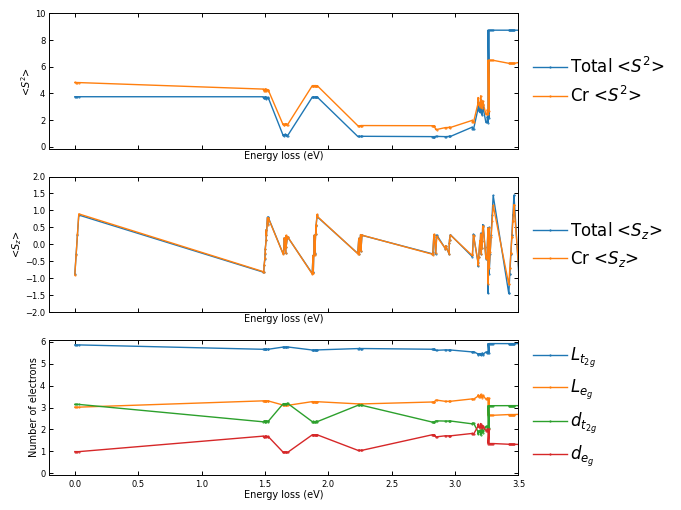

In [13]:
evals = rixs_ana_results['evals']
S2_all_val = rixs_ana_results['S2_all_val']
Sz_all_val = rixs_ana_results['Sz_all_val']
S2_Cr_val = rixs_ana_results['S2_Cr_val']
Sz_Cr_val = rixs_ana_results['Sz_Cr_val']
d_eg = rixs_ana_results['d_eg']
d_t2g = rixs_ana_results['d_t2g']
L_eg = rixs_ana_results['L_eg']
L_t2g = rixs_ana_results['L_t2g']


fig, axs = plt.subplots(3, 1, figsize=(7,6), sharex=True, gridspec_kw=dict(left=0.08, right=0.75))

marker = '.'
ms = 1
xlim=[-0.2,3.5]
ylim=[-0.2,10]

ax = axs[0]
ax.plot(evals, S2_all_val, '-', marker=marker, ms=ms, label=r'Total <$S^2$>')
ax.plot(evals, S2_Cr_val, '-', marker=marker, ms=ms, label=r'Cr <$S^2$>')
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('<$S^2$>')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(fontsize=12, )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

ax = axs[1]
ax.plot(evals, Sz_all_val, '-', marker=marker, ms=ms, label=r'Total <$S_z$>')
ax.plot(evals, Sz_Cr_val, '-', marker=marker, ms=ms, label=r'Cr <$S_z$>')
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('<$S_z$>')
ax.set_xlim(xlim)
ax.set_ylim(-2, 2)
ax.legend(fontsize=12, )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)


ax = axs[2]
ax.plot(evals, L_t2g, '-', marker=marker, ms=ms, label=r'$L_{t_{2g}}$')
ax.plot(evals, L_eg, '-', marker=marker, ms=ms, label=r'$L_{e_g}$')
ax.plot(evals, d_t2g, '-', marker=marker, ms=ms, label=r'$d_{t_{2g}}$')
ax.plot(evals, d_eg, '-', marker=marker, ms=ms, label=r'$d_{e_g}$')

ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('Number of electrons')
ax.set_xlim(xlim)
ax.set_ylim(-0.1, 6.1)
ax.legend(fontsize=12, )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)


# Calculate XAS

In [14]:
np.set_printoptions(precision=3, suppress=True)
print("Eigenvalues:")
print(eval_i - eval_i[0])

print("Boltzmann distribution:")
print(edrixs.boltz_dist(eval_i, T=30))

Eigenvalues:
[0.    0.01  0.021 0.031 1.485 1.49  1.494 1.499 1.501 1.502 1.51  1.51
 1.511 1.52  1.521 1.526 1.642 1.645 1.649 1.65  1.66  1.663 1.664 1.666
 1.677 1.678 1.873 1.879 1.881 1.881 1.889 1.893 1.893 1.902 1.903 1.904
 1.912 1.912 2.232 2.24  2.244 2.254 2.257 2.265 2.82  2.824 2.824 2.832
 2.834 2.836 2.847 2.855 2.924 2.925 2.953 2.954 2.956 2.963 3.135 3.137
 3.145 3.146 3.181 3.182 3.186 3.196 3.197 3.202 3.207 3.208 3.209 3.214
 3.218 3.222 3.243 3.253 3.254 3.26  3.26  3.26  3.268 3.268 3.276 3.284
 3.292 3.3   3.423 3.424 3.432 3.432 3.44  3.44  3.448 3.448 3.456 3.456
 3.464 3.465 3.512 3.52 ]
Boltzmann distribution:
[0.982 0.018 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0. 

In [15]:
ominc_xas = om_shift + np.linspace(-8, 12, 300)

temperature = 30
num_gs = 2 # Number of initial states used in XAS calculations.
nkryl = 200 # Maximum number of poles obtained.

thin = np.deg2rad(14.5)
tth = np.deg2rad(150)
thout = tth - thin
phi = np.deg2rad(90)

gamma_c = 0.3 # The core-hole life-time broadening factor (HWHM)

poltype_xas = [('linear', 0), ('linear', np.pi/2)] # ['LH', 'LV']
scatter_axis = rmat_t2o_DFT().T # The local axis defining the scattering geometry. The scattering plane is defined in the local `zx`-plane. This applies to the polarization vectors. 

In [16]:
xas, xas_poles = edrixs.xas_siam_fort(
    comm, shell_name, nbath, ominc_xas, gamma_c=gamma_c, v_noccu=v_noccu, thin=thin,
    phi=phi, num_gs=num_gs, nkryl=nkryl, pol_type=poltype_xas, temperature=temperature, 
    scatter_axis=scatter_axis, 
)

edrixs >>> Running XAS ...
edrixs >>> Loop over for polarization:  0 linear
 ---------------------------
  fedrixs >>> XAS Begin ... 


     num_val_orbs:               20
     num_core_orbs:               6
     ndim_i:                  77520
     ndim_n:                 232560
     nhopp_n:                   220
     ncoul_n:                   932
     num_gs:                      2
     nkryl:                     200

  fedrixs >>> For ground state:            1
     Building transition operator for absorption process ...
     Done !

     Apply transition operator on the ground state to get intermediate state...
     Done !

     Build Hamiltonian for intermediate configuration...
     Allocate memory for ham_csr ...
     Really building Hamiltonian begin here ...
     Number of nonzero elements of intermediate Hamiltonian:              12329376
     Done !

     Building Krylov space for XAS spectrum ...
     Krylov iteration:     50
     Krylov iteration:    100
     Krylov itera

(573.0, 581.0)

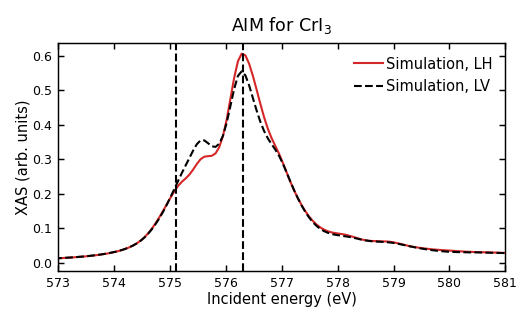

In [17]:
mm = 1/25.4  # centimeters in inches
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(88*mm,50*mm), gridspec_kw=dict(wspace=0.08, top=0.9, left=0.11, bottom=0.13,right=0.97))
title = "AIM for CrI$_3$"

eshift = 3.5 # adjusted to match the experimental value of the resonant energy

ax.plot(ominc_xas+eshift, xas[:,0], color='C3', ls='-', lw=1, label='Simulation, LH')
ax.plot(ominc_xas+eshift, xas[:,1], color='k', ls='--', lw=1, label='Simulation, LV')
ax.legend(frameon=False)
ax.set_xlabel('Incident energy (eV)')
ax.set_ylabel('XAS (arb. units)')
ax.set_title(title)

ax.axvline(x=575.1, color='k', ls='--')
ax.axvline(x=576.3, color='k', ls='--')

ax.set_xlim(573, 581)

# Calculate RIXS at the main resonant energy (i.e., 576.3 eV)

In [18]:
ominc_rixs = np.array([576.3]) - eshift
eloss = np.linspace(-1, 3.5, 450*2+1)

temperature = 30
num_gs = 2 # Number of initial states used in XAS calculations.
nkryl = 300 # Maximum number of poles obtained.

thin = np.deg2rad(14.5)
tth = np.deg2rad(150)
thout = tth - thin
phi = np.deg2rad(90)

gamma_c = 0.3 # The core-hole life-time broadening factor (HWHM)
gamma_f = 0.015 # The final states life-time broadening factor (HWHM)


poltype_rixs = [('linear', 0, 'linear', 0), ('linear', 0, 'linear', np.pi/2)] # 'LH'
scatter_axis = rmat_t2o_DFT().T # The local axis defining the scattering geometry. The scattering plane is defined in the local `zx`-plane.

In [19]:
rixs, _ = edrixs.rixs_siam_fort(comm=comm, shell_name=shell_name, nbath=nbath, ominc=ominc_rixs, eloss=eloss, gamma_c=gamma_c, 
                                gamma_f=gamma_f, v_noccu=v_noccu, thin=thin, thout=thout, phi=phi, num_gs=num_gs, nkryl=nkryl, 
                                pol_type=poltype_rixs, temperature=temperature, scatter_axis=scatter_axis)
rixs = np.sum(rixs, axis=2)

eval_i = eval_i - eval_i[0]
rixs_poles, _ = edrixs.rixs_siam_fort(comm=comm, shell_name=shell_name, nbath=nbath, ominc=ominc_rixs, eloss=eval_i, gamma_c=gamma_c, 
                                      gamma_f=gamma_f/10, v_noccu=v_noccu, thin=thin, thout=thout, phi=phi, num_gs=num_gs, nkryl=nkryl, 
                                      pol_type=poltype_rixs, temperature=temperature,scatter_axis=scatter_axis,)
rixs_poles = np.sum(rixs_poles, axis=2)/10

edrixs >>> Running RIXS ...

edrixs >>> Calculate RIXS for incident energy:  572.8
edrixs >>> Polarization:  0
  fedrixs >>> RIXS Begin ...

     num_val_orbs:               20
     num_core_orbs:               6
     ndim_i:                  77520
     ndim_n:                 232560
     ndim_f:                  77520
     nhopp_i:                   210
     nhopp_n:                   220
     ncoul_i:                   340
     ncoul_n:                   932
     num_gs:                      2
     nkryl:                     300
     linsys_max:               1000
     linsys_tol:           0.10E-09
     omega_in:           572.800000
     gamma_in              0.300000

  fedrixs >>> For initial state:             1
     Building transition operator for absorption process ...
     Done !

     Apply transition operator on the ground state to get intermediate state...
     Done !

     Building Hamiltonian for intermediate configuration ...
     Allocate memory for ham_csr ...
     R

Text(0.5, 1.0, '')

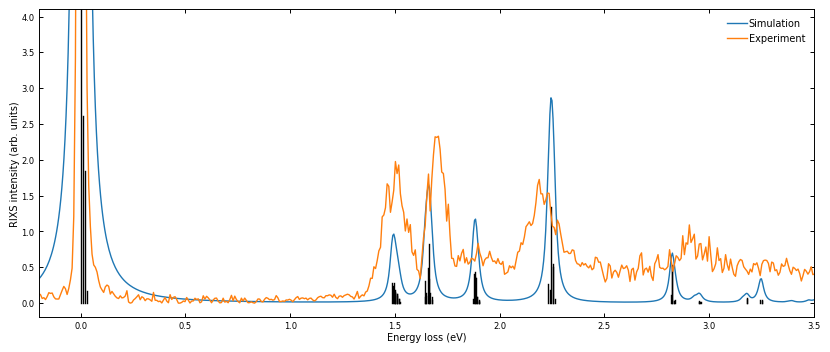

In [20]:
fig, ax = plt.subplots(figsize=(10,4))


ax.plot(eloss, rixs[0], label='Simulation')
for E, h in zip(eval_i, rixs_poles[0]):
    ax.plot([E, E], [0, h], '-', color='k')

fname = '../RIXS_Edep_LH_576p3eV.txt'
eloss_exp, rixs_exp = np.loadtxt(fname, unpack=True, comments='# ')
scale_exp = 10
ax.plot(eloss_exp, rixs_exp * scale_exp, label='Experiment')

ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('RIXS intensity (arb. units)')
ax.legend()

xlim=[-0.2, 3.5]
ylim=[-0.2,4.1]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

title = "AIM for CrI$_3$"
ax.set_title('')

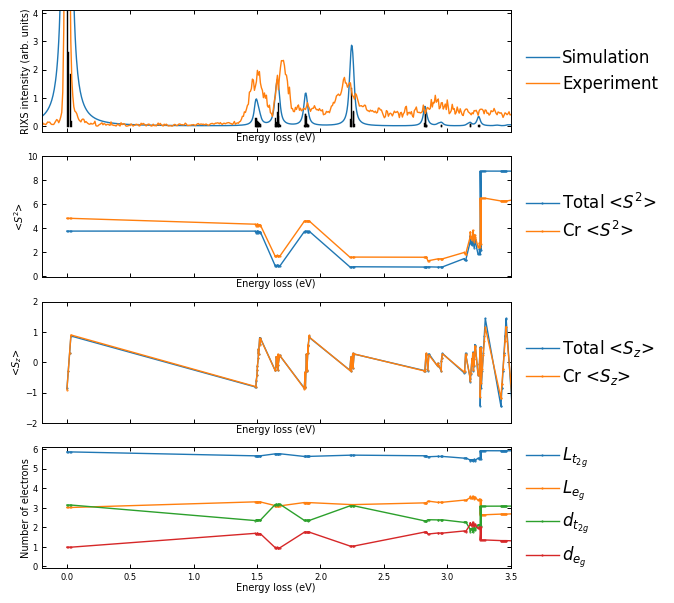

In [21]:
evals = rixs_ana_results['evals']
S2_all_val = rixs_ana_results['S2_all_val']
Sz_all_val = rixs_ana_results['Sz_all_val']
S2_Cr_val = rixs_ana_results['S2_Cr_val']
Sz_Cr_val = rixs_ana_results['Sz_Cr_val']
d_eg = rixs_ana_results['d_eg']
d_t2g = rixs_ana_results['d_t2g']
L_eg = rixs_ana_results['L_eg']
L_t2g = rixs_ana_results['L_t2g']

fig, axs = plt.subplots(4, 1, figsize=(7,6), sharex=True, gridspec_kw=dict(left=0.08, right=0.75, top=0.98, bottom=0.05))

marker = '.'
ms = 1
xlim=[-0.2, 3.5]
ylim=[-0.2,4.1]


ax = axs[0]
ax.plot(eloss, rixs[0], label='Simulation')
for E, h in zip(eval_i, rixs_poles[0]):
    ax.plot([E, E], [0, h], '-', color='k')
scale_exp = 10
ax.plot(eloss_exp, rixs_exp * scale_exp, label='Experiment')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('RIXS intensity (arb. units)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

ax = axs[1]
ax.plot(evals, S2_all_val, '-', marker=marker, ms=ms, label=r'Total <$S^2$>')
ax.plot(evals, S2_Cr_val, '-', marker=marker, ms=ms, label=r'Cr <$S^2$>')
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('<$S^2$>')
ax.set_xlim(xlim)
ax.set_ylim(-0.1, 10)
ax.legend(fontsize=12, )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

ax = axs[2]
ax.plot(evals, Sz_all_val, '-', marker=marker, ms=ms, label=r'Total <$S_z$>')
ax.plot(evals, Sz_Cr_val, '-', marker=marker, ms=ms, label=r'Cr <$S_z$>')
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('<$S_z$>')
ax.set_xlim(xlim)
ax.set_ylim(-2, 2)
ax.legend(fontsize=12, )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)


ax = axs[3]
ax.plot(evals, L_t2g, '-', marker=marker, ms=ms, label=r'$L_{t_{2g}}$')
ax.plot(evals, L_eg, '-', marker=marker, ms=ms, label=r'$L_{e_g}$')
ax.plot(evals, d_t2g, '-', marker=marker, ms=ms, label=r'$d_{t_{2g}}$')
ax.plot(evals, d_eg, '-', marker=marker, ms=ms, label=r'$d_{e_g}$')

ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('Number of electrons')
ax.set_xlim(xlim)
ax.set_ylim(-0.1, 6.1)
ax.legend(fontsize=12, )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)


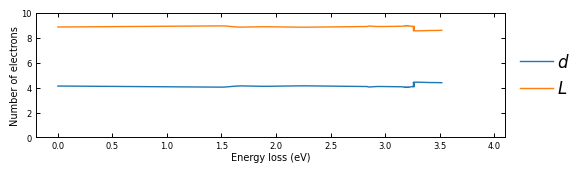

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7,1.5), gridspec_kw=dict(left=0.08, right=0.75, top=0.98, bottom=0.15))


ax.plot(evals, d_eg+d_t2g, label='$d$')
ax.plot(evals, L_eg+L_t2g, label='$L$')

ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('Number of electrons')
ax.set_xlim(-0.2, 4.1)
ax.set_ylim(0,10)
ax.legend(fontsize=12, )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

